In [1]:
import pandas as pd
import numpy as np
import statistics

import seaborn as sns
from matplotlib import pyplot as plt

from scipy import stats


import operator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

### **Import** DataBase

In [2]:
df = pd.read_csv('Property_structured_data.csv')

In [3]:
df_shape_initial = df.shape

### **Clean** DataBase

Transform the data into digits, drop elements that are outliers

#### **Price** (float)

In [4]:
z_scores_price = stats.zscore(df['price'])
abs_z_scores_price = np.abs(z_scores_price) 
filtered_entries_price = (abs_z_scores_price < 2)
df = df[filtered_entries_price]

In [5]:
df.loc[df["price"] >= 800000, "type_of_property"] = "OTHER"

In [6]:
df= df.loc[df['price'] != -1]

#### **Surface** (float)

In [7]:
df = df.loc[df['surface'] <= 800]

In [8]:
df = df.loc[df['surface'] >= 35]

In [9]:
df = df.loc[df['surface'] != -1]

#### **Sub type of property** (str)

In [10]:
df['subtype_of_property'].value_counts()

HOUSE                   20327
APARTMENT               15512
VILLA                    2560
APARTMENT_BLOCK          1274
DUPLEX                   1207
GROUND_FLOOR             1124
PENTHOUSE                 928
MIXED_USE_BUILDING        911
SERVICE_FLAT              471
EXCEPTIONAL_PROPERTY      460
FLAT_STUDIO               450
MANSION                   419
TOWN_HOUSE                375
COUNTRY_COTTAGE           284
BUNGALOW                  239
LOFT                      216
FARMHOUSE                 139
TRIPLEX                   112
CHALET                    101
OTHER_PROPERTY             65
MANOR_HOUSE                54
CASTLE                      8
KOT                         8
PAVILION                    1
Name: subtype_of_property, dtype: int64

In [11]:
df= df.loc[df['subtype_of_property'] != 'APARTMENT_BLOCK']

In [12]:
df= df.loc[df['subtype_of_property'] != 'MIXED_USE_BUILDING']

In [13]:
others = ["CHALET", "MANOR_HOUSE", "OTHER_PROPERTY", "CASTLE", "PAVILION"]

In [14]:
df.loc[df["subtype_of_property"].isin(others), "type_of_property"] = "OTHER"

#### **Number of bedrooms** (int)

In [15]:
df = df.loc[df['number_of_bedrooms'] <20]

In [16]:
df['type_of_property'] = np.where((df['number_of_bedrooms'] > 20), "OTHER", df['type_of_property'])

In [17]:
df['number_of_bedrooms'] = df['number_of_bedrooms'].replace(-1,0)

#### **Zip Code** (category)

In [18]:
df['zip_code_xx'] = df['postal_code'].apply(lambda x : 'be_zip_'+str(x)[:2])

#### **Land surface** (float)

In [19]:
df['land_surface'] = [land_surface if land_surface != -1 else garden_surface if garden_surface > 0 else land_surface for garden_surface,land_surface in zip(df['garden_surface'],df['land_surface'])]

In [20]:
df['land_surface'] = df['land_surface'].replace(-1,0)

#### **Garden** (0,1)

In [21]:
df['garden'] = df['garden'].replace(-1,0)

#### **Garden surface** (float)

In [22]:
df['garden_surface'] = df['garden_surface'].replace(-1,0)

In [23]:
df['garden_surface'] = df['garden_surface'].replace(1,0)

#### **Fully equiped kitchen** (int)

In [24]:
df["fully_equipped_kitchen"] = df["fully_equipped_kitchen"].map({"-1.0": 0.25, "1.0": 1,"-1": 0.25, "1": 1, "INSTALLED": 0.5, "SEMI_EQUIPPED": 0.75, "NOT_INSTALLED": 0, "USA_INSTALLED": 0.5, "USA_SEMI_EQUIPPED": 0.75, "USA_UNINSTALLED": 0})

In [25]:
#df["fully_equipped_kitchen"] = df["fully_equipped_kitchen"].map({"-1.0": 0, "1.0": 1,"-1": 0, "1": 1, "INSTALLED": 0, "SEMI_EQUIPPED": 1, "NOT_INSTALLED": 0, "USA_INSTALLED": 0, "USA_SEMI_EQUIPPED": 1, "USA_UNINSTALLED": 0})

#### **Swiming pool**  (0,1)

In [26]:
df['swimming_pool'] = df['swimming_pool'].replace(-1,0)

#### **Furnished** (0,1)

In [27]:
df['furnished'] = df['furnished'].replace(-1,0)

#### **Open fire** (0,1)

In [28]:
df['open_fire'] = df['open_fire'].replace(-1,0)

#### **Terrace** (0,1)

In [29]:
df['terrace'] = df['terrace'].replace(-1,0)

#### **Terrace surface** (float)

In [30]:
df = df.loc[df['terrace_surface'] < 500]

In [31]:
df['terrace_surface'] = df['terrace_surface'].replace(-1,0)

#### **Facades** (int)

In [32]:
df = df.loc[df["number_of_facades"] < 9]

In [33]:
df["number_of_facades"] = np.where((df["number_of_facades"] == -1) & (df["type_of_property"] == "APARTMENT"), 1, df["number_of_facades"])

In [34]:
df["number_of_facades"] = np.where((df["number_of_facades"] == -1) & (df["type_of_property"] == "HOUSE"), 2, df["number_of_facades"])

In [35]:
df = df.loc[df["number_of_facades"] != -1]

#### **State of the building** (int)

In [36]:
df["state_of_the_building"] = df["state_of_the_building"].map({
    "NO_INFO": 0.25, #"TO_RENOVATE"
    "TO_BE_DONE_UP": 0.75, #"JUST_RENOVATED"
    "TO_RENOVATE": 0.25, #"TO_RENOVATE"
    "TO_RESTORE": 0.25, #"TO_REBUILD"
    "JUST_RENOVATED": 0.75, #"JUST_RENOVATED"
    "GOOD": 0.5, #"GOOD"
    "AS_NEW": 1.0 #"NEW"
})

#### **Type of property** (category)

In [37]:
df_other = df.loc[df["type_of_property"] == "OTHER"]

In [38]:
df= df.loc[df["type_of_property"] != "OTHER"]

### **Add Values** to DataBase

#### **price/m²** calculate(float)

In [39]:
df['price_m2'] = round(df['price']/df['surface'],2)

#### **zipcode ratio** calculate(float)

Calculate the mean value of price/m² by zip

In [40]:
df_zip_list = ['price_m2','zip_code_xx']

In [41]:
df_zips = df[df_zip_list]

In [42]:
xxx_zip = df_zips.groupby('zip_code_xx')

In [43]:
xxx_zip_list = []  #stores the name of each zipcode from the data base
for key, values in xxx_zip:
    xxx_zip_list.append(key)

In [44]:
df_zips_mean = round(df_zips.groupby('zip_code_xx').mean(),2)

In [45]:
df_zips_mean_values = df_zips_mean.values  # calculates mean for each zipxx

In [46]:
zip_mean = [] # stores the values as a list of mean for each zipxx
for x in df_zips_mean_values:
    for i in x:
        zip_mean.append(i)

In [47]:
global_mean = statistics.mean(zip_mean)  #calculate a global mean

In [48]:
xxx = [] #list of the ponderated means 
for y,i in enumerate(zip_mean):
    xxx.append(round(i/global_mean,2)) #calculates the relation of mean/zip code and the global mean

Send this to the data frame as a column

In [49]:
dic_zip_value = dict()  #creates a dictionay for zipcodes and values
for i,x in enumerate(xxx_zip_list):
    dic_zip_value[x] = xxx[i]

In [50]:
df['zip_code_ratio'] = df['zip_code_xx']

In [51]:
df['zip_code_ratio'] = df['zip_code_ratio'].map(dic_zip_value)

### **Check** DataBase

In [52]:
filtered_atributes = [#'id',
 #'locality',
 #'postal_code',
 #'region',
 #'province',
 'type_of_property',
 #'subtype_of_property',
 #'type_of_sale',
 'price',
 'number_of_bedrooms',
 'surface',
 #'kitchen_type',
 'fully_equipped_kitchen',
 'furnished',
 'open_fire',
 'terrace',
 'terrace_surface',
 'garden',
 'garden_surface',
 'land_surface',
 'number_of_facades',
 'swimming_pool',
 'state_of_the_building',
 #'zip_code_xx',
 #'price_m2',
 'zip_code_ratio']

In [53]:
df = df[filtered_atributes]

In [54]:
df_shape_final = df.shape

In [55]:
print(f'initial_df {df_shape_initial} claned_df {df_shape_final}')

initial_df (62430, 23) claned_df (42930, 16)


In [56]:
df.describe()

,price,number_of_bedrooms,surface,fully_equipped_kitchen,furnished,open_fire,terrace,terrace_surface,garden,garden_surface,land_surface,number_of_facades,swimming_pool,state_of_the_building,zip_code_ratio
count,42930.000000,42930.000000,42930.000000,42930.000000,42930.000000,42930.000000,42930.000000,42930.000000,42930.000000,42930.000000,4.293000e+04,42930.000000,42930.000000,42930.000000,42930.000000
mean,326038.838714,2.736921,147.532541,0.502615,0.022246,0.039646,0.635127,9.524482,0.340997,110.448241,4.607907e+02,2.378989,0.013557,0.554251,1.104942
std,150093.338928,1.224795,79.470420,0.278007,0.147483,0.195128,0.481400,18.933273,0.474050,1105.380100,5.974487e+03,0.981126,0.115644,0.290610,0.297575
min,2500.000000,0.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.250000,0.550000
25%,220000.000000,2.000000,93.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000,0.000000,0.250000,0.890000
50%,295000.000000,3.000000,130.000000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.100000e+01,2.000000,0.000000,0.500000,1.070000
75%,399000.000000,3.000000,180.000000,0.750000,0.000000,0.000000,1.000000,13.000000,1.000000,0.000000,4.180000e+02,3.000000,0.000000,0.750000,1.350000
max,799950.000000,17.000000,800.000000,1.000000,1.000000,1.000000,1.000000,420.000000,1.000000,100000.000000,1.100000e+06,6.000000,1.000000,1.000000,1.980000


In [57]:
for index,atribute in enumerate(df.columns.to_list()):
    print(atribute)
    print(df[df.columns.to_list()[index]].value_counts())
    print('\n')

type_of_property
HOUSE        23501
APARTMENT    19429
Name: type_of_property, dtype: int64


price
299000    757
249000    670
295000    663
199000    614
275000    595
         ... 
537334      1
468900      1
224242      1
266225      1
316200      1
Name: price, Length: 3605, dtype: int64


number_of_bedrooms
3     14386
2     14331
4      6087
1      4623
5      1990
6       641
0       511
7       176
8        92
9        53
10       15
11       11
12        5
16        2
13        2
15        2
14        2
17        1
Name: number_of_bedrooms, dtype: int64


surface
100    875
150    869
90     829
120    801
110    703
      ... 
393      1
788      1
705      1
612      1
595      1
Name: surface, Length: 562, dtype: int64


fully_equipped_kitchen
0.50    15960
0.25    14072
1.00     6936
0.75     4191
0.00     1771
Name: fully_equipped_kitchen, dtype: int64


furnished
0    41975
1      955
Name: furnished, dtype: int64


open_fire
0    41228
1     1702
Name: open_fire, dtype

### **Separate** DataBase Houses / Apartments

In [58]:
df_house = df.loc[df["type_of_property"] == "HOUSE"]

In [59]:
df_apartment = df.loc[df["type_of_property"] == "APARTMENT"]

### Data **Exploration**

#### **Select** atributes

In [60]:
atributes_house=[#'type_of_property',
 'price',
 'number_of_bedrooms',
 'surface',
 #'fully_equipped_kitchen',
 #'furnished',
 #'open_fire',
 #'terrace',
 #'terrace_surface',
 #'garden',
 #'garden_surface',
 #'land_surface',
 #'number_of_facades',
 #'swimming_pool',
 #'state_of_the_building',
 'zip_code_ratio']

In [61]:
df_house = df_house[atributes_house]

In [62]:
atributes_apartment=[#'type_of_property',
 'price',
 'number_of_bedrooms',
 'surface',
 #'fully_equipped_kitchen',
 #'furnished',
 #'open_fire',
 #'terrace',
 'terrace_surface',
 #'garden',
 #'garden_surface',
 #'land_surface',
 #'number_of_facades',
 #'swimming_pool',
 #'state_of_the_building',
 'zip_code_ratio']

In [63]:
df_apartment = df_apartment[atributes_apartment]

#### Attributes **correlation**

In [64]:
df_house.corr()['price']

price                 1.000000
number_of_bedrooms    0.384784
surface               0.533437
zip_code_ratio        0.446084
Name: price, dtype: float64

**Relationship of house atributes wit price:**
* **number_of_bedrooms        0.384784**
* **surface                   0.533437**
* fully_equipped_kitchen    0.209290
* open_fire                 0.145386
* number_of_facades         0.253947
* swimming_pool             0.160394
* state_of_the_building     0.173194
* **zip_code_ratio            0.446084**

In [65]:
df_apartment.corr()['price']

price                 1.000000
number_of_bedrooms    0.410458
surface               0.537731
terrace_surface       0.301534
zip_code_ratio        0.341447
Name: price, dtype: float64

**Relationship of apartment atributes wit price:**
* **number_of_bedrooms        0.410458**
* **surface                   0.537731**
* fully_equipped_kitchen    0.170661
* terrace                   0.177441
* **terrace_surface           0.301534**
* state_of_the_building     0.150617
* **zip_code_ratio            0.341447**

#### Data **Exploration**

In [66]:
def plt_chart(chart_x, chart_y, chart_title, chart_x_label, chart_y_label):
    plt.scatter(chart_x, chart_y)
    plt.title(chart_title)
    plt.ylabel(chart_y_label)
    plt.xlabel(chart_x_label)
    return plt

<module 'matplotlib.pyplot' from '/home/david/MyGithub/challenge-regression/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

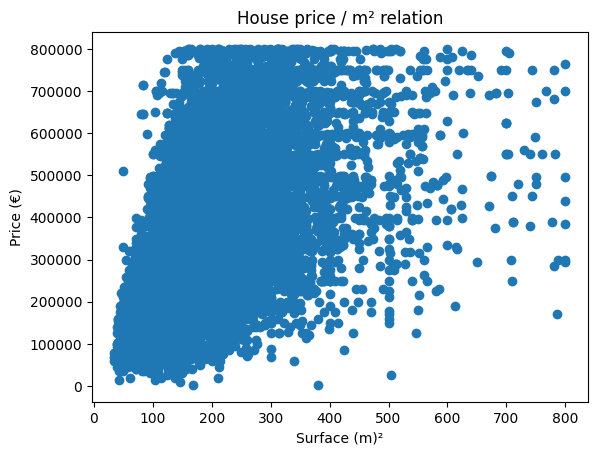

In [67]:
plt_chart(df_house['surface'],df_house['price'],'House price / m² relation','Surface (m)²','Price (€)')

<module 'matplotlib.pyplot' from '/home/david/MyGithub/challenge-regression/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

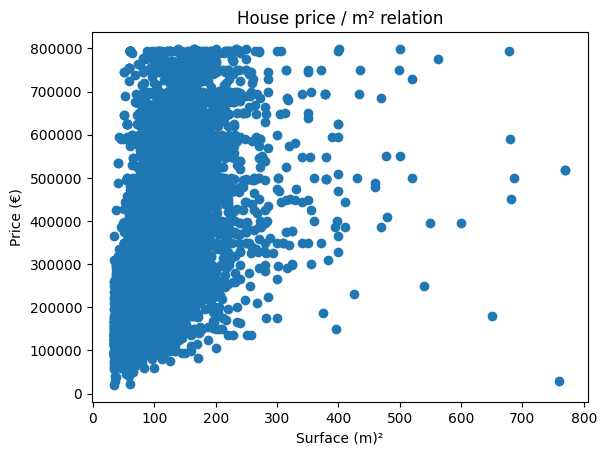

In [68]:
plt_chart(df_apartment['surface'],df_apartment['price'],'House price / m² relation','Surface (m)²','Price (€)')

/tmp/ipykernel_16763/2064535743.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_house['price'], bins=30)


<AxesSubplot: xlabel='price', ylabel='Density'>

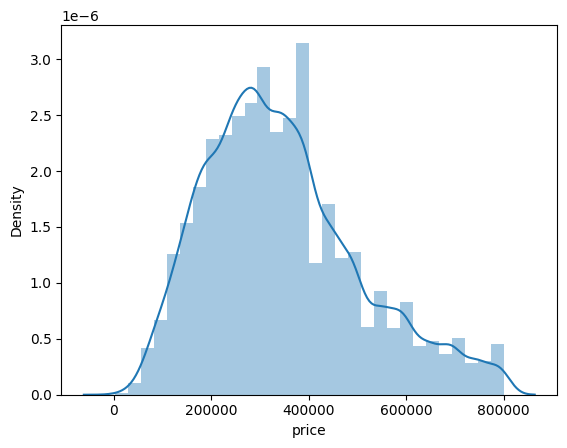

In [69]:
sns.distplot(df_house['price'], bins=30)

/tmp/ipykernel_16763/2610420630.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_apartment['price'], bins=30)


<AxesSubplot: xlabel='price', ylabel='Density'>

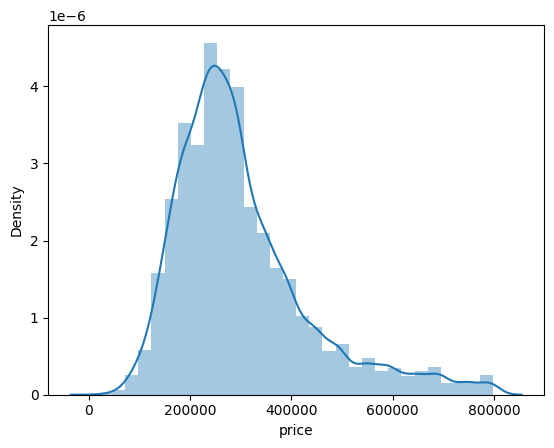

In [70]:
sns.distplot(df_apartment['price'], bins=30)

<AxesSubplot: >

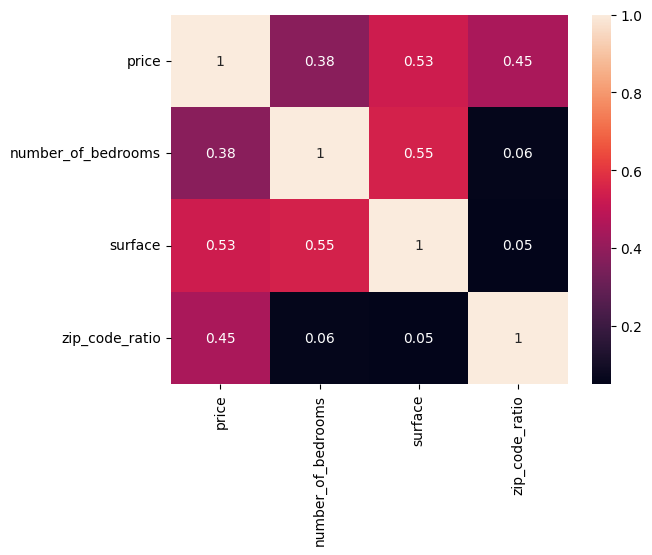

In [71]:
correlation_matrix_house = df_house.corr().round(2)
sns.heatmap(data=correlation_matrix_house, annot=True)

<AxesSubplot: >

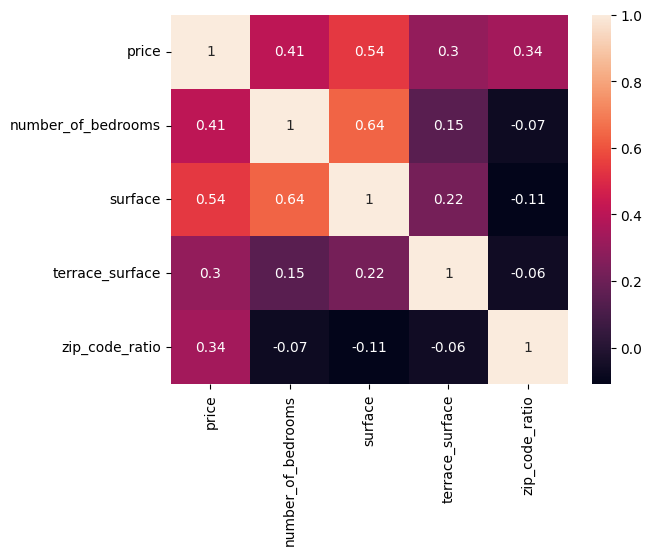

In [72]:
correlation_matrix_apartment = df_apartment.corr().round(2)
sns.heatmap(data=correlation_matrix_apartment, annot=True)

## **ML regresion**

- learning rate
- overfiting
- test and plot
- use the same seed for shuffle
- use polinoms

### House model / Lineal Regresion

#### **Prepare** X and Y

In [73]:
X = df_house.iloc[:,1:].values  #features

In [74]:
Y = df_house.iloc[:,0].values  #target : price

#### **Split** the Data

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(18800, 3)
(4701, 3)
(18800,)
(4701,)


#### **Training and testing** the model

In [76]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

#### **Model evaluation**

Evaluate our model using RMSE and R2-score.

In [77]:
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 115898.63149298531
R2 score is 0.4657210046900937


In [78]:
# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
RMSE is 117988.30659226008
R2 score is 0.48103531220952755


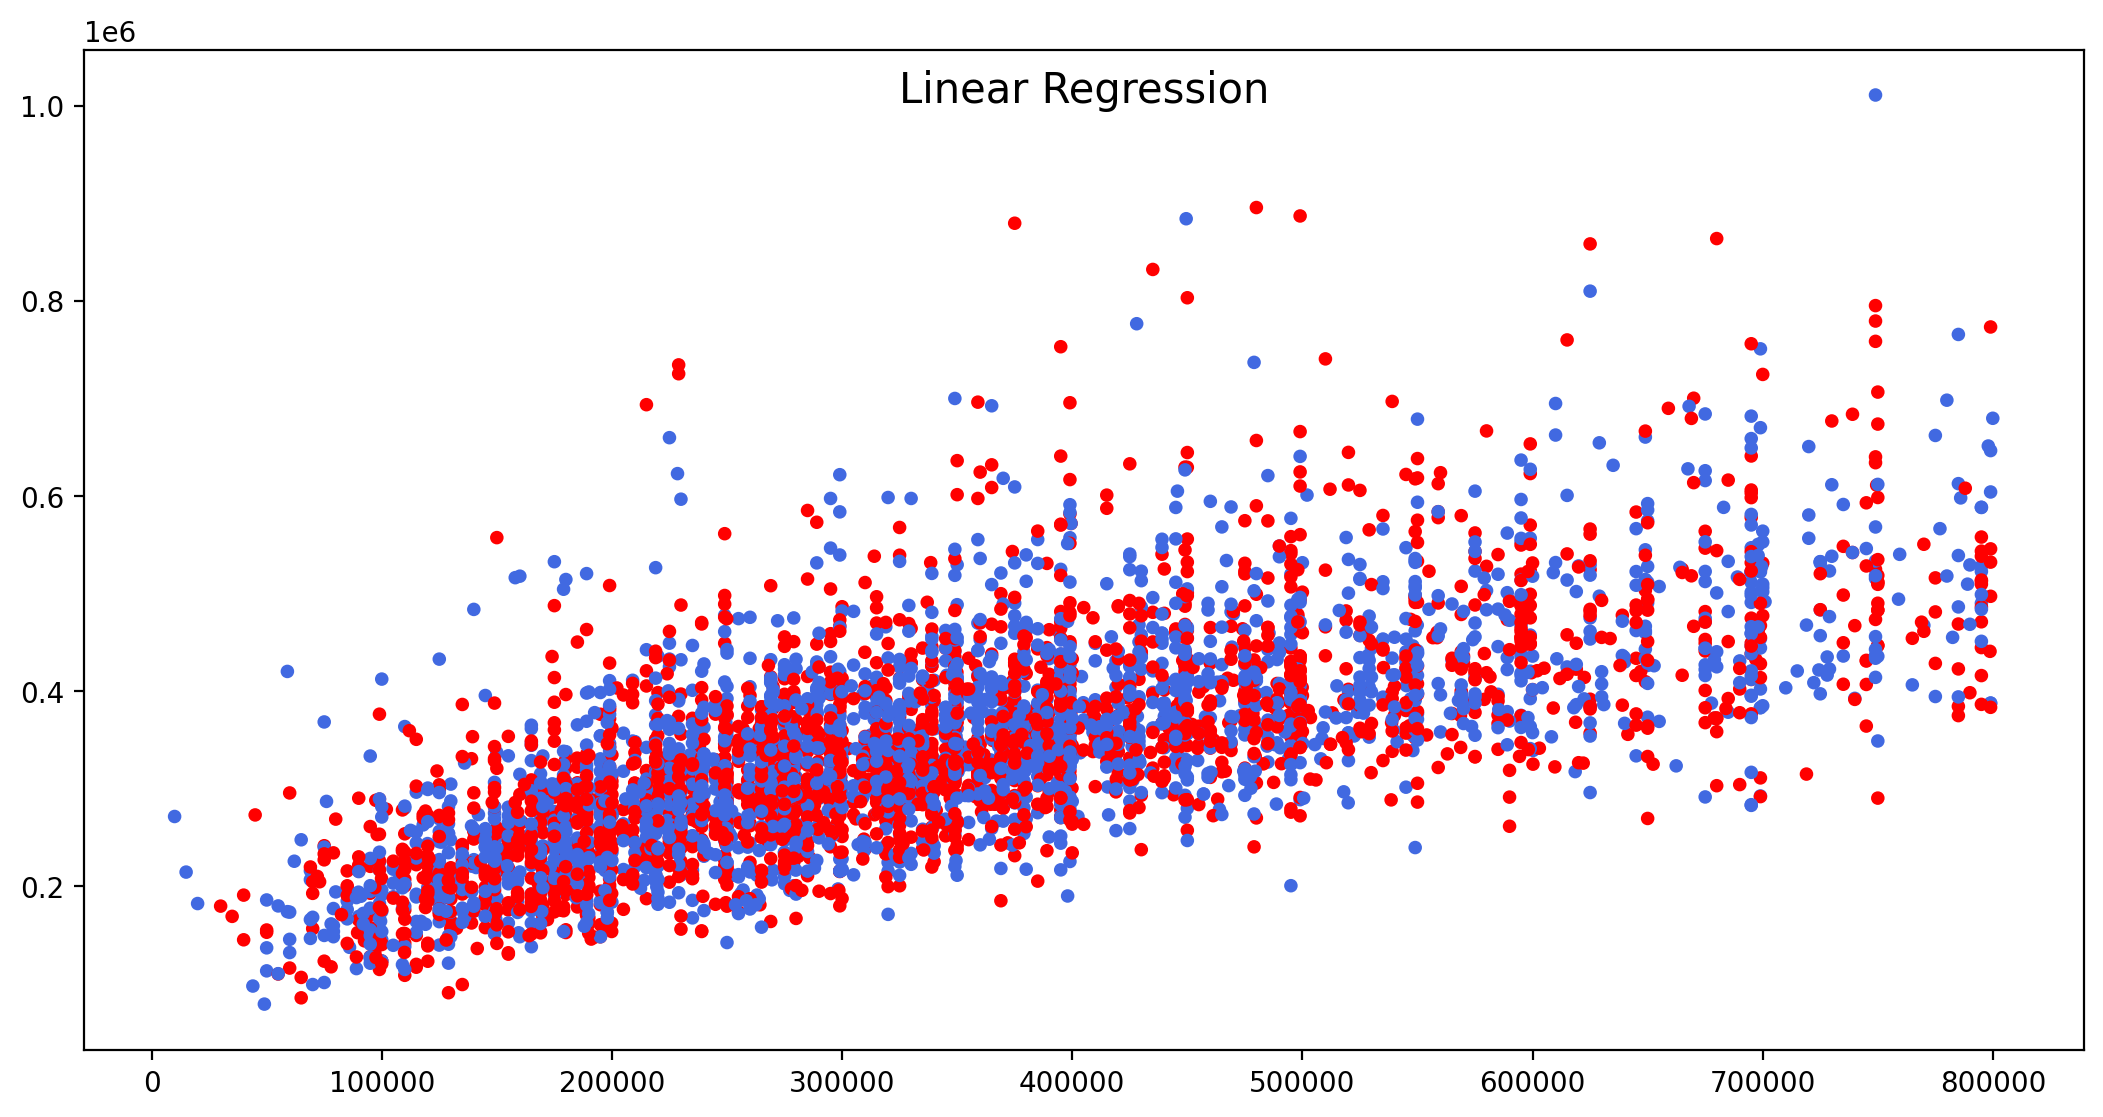

In [79]:
fig = plt.figure(figsize=(10,5), dpi=200)
axes = fig.add_axes([0, 0, 1, 1])
fig.suptitle("Linear Regression", fontsize=15)

# plotting the y_test vs y_pred
# ideally should have been a straight line
plt.scatter(Y_test, y_test_predict, s=15).set_color(['royalblue','red'])
plt.show()

### Polynominal Regresion

In [80]:
def create_polynomial_regression_model(degree):
    "Creates a polynomial regression model for the given degree"
    poly_features = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, Y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)
  
    # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
    r2_train = r2_score(Y_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    r2_test = r2_score(Y_test, y_test_predict)

#     print("The model performance for the training set")
#     print("-------------------------------------------")
#     print("RMSE of training set is {}".format(rmse_train))
#     print("R2 score of training set is {}".format(r2_train))

#     print("\n")
  
#     print("The model performance for the test set")
#     print("-------------------------------------------")
#     print("RMSE of test set is {}".format(rmse_test))
#     print("R2 score of test set is {}".format(r2_test))
    
    result= {'Degree':degree,'rmse_train':round(rmse_train,2),'r2_train':round(r2_train,2),'rmse_test':round(rmse_test,2),'r2_test':round(r2_test,2)}
    return result

In [81]:
results_list = []

In [82]:
for i in range(1,10):
    results_list.append(create_polynomial_regression_model(i))

In [83]:
df_results = pd.DataFrame(results_list)

In [84]:
df_results

,Degree,rmse_train,r2_train,rmse_test,r2_test
0,1,115898.63,0.47,117988.31,0.48
1,2,110401.39,0.52,112998.87,0.52
2,3,109794.09,0.52,111974.26,0.53
3,4,109625.64,0.52,111779.10,0.53
4,5,109458.51,0.52,111685.75,0.53
5,6,109369.48,0.52,113135.15,0.52
6,7,110624.32,0.51,132601.42,0.34
7,8,117301.36,0.45,156646.89,0.09
8,9,259089.85,-1.67,1554902.40,-89.13


Text(0.5, 0, 'Degree')

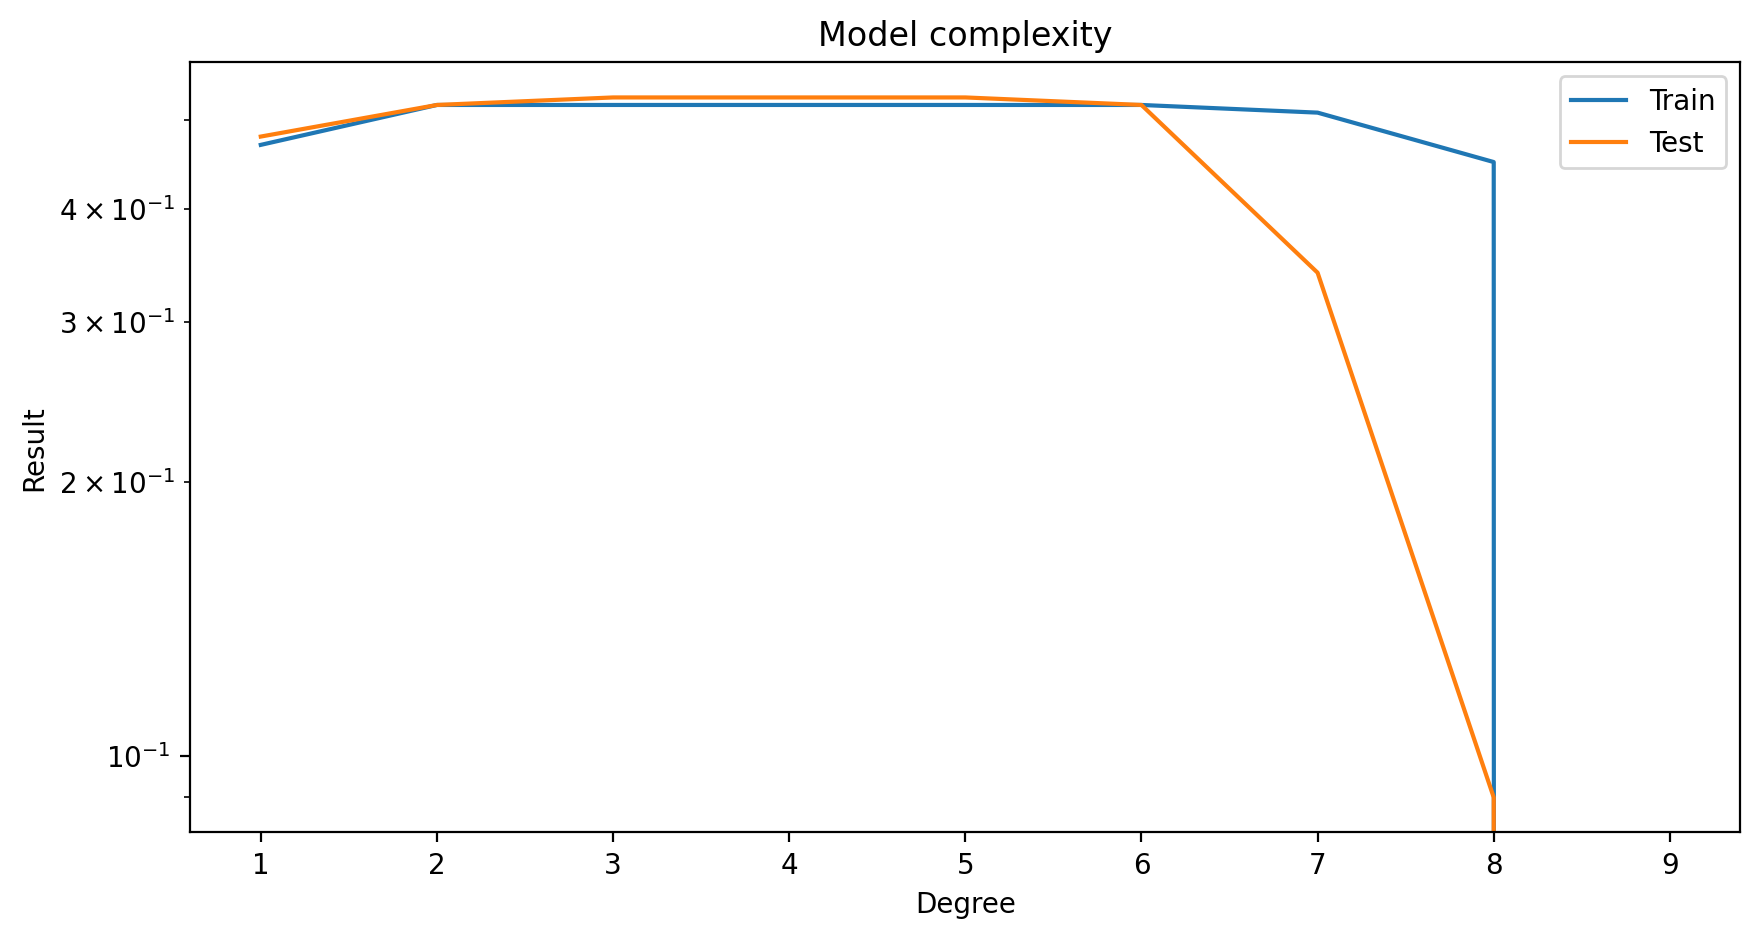

In [87]:
fig = plt.figure(figsize=(10,5), dpi=200)
plt.plot(df_results['Degree'], df_results['r2_train'], label='Train')
plt.plot(df_results['Degree'], df_results['r2_test'], label='Test')
plt.yscale('log')
plt.legend()
plt.title('Model complexity')
plt.ylabel('Result')
plt.xlabel('Degree')